# Single Stock ML Model Objective

This notebook is dedicated to developing a robust classifier aimed at predicting the direction (upward or downward) of a stock's weekly movement.

In [33]:
import pandas as pd
import numpy as np

#ML metrics and preprocessing  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split 

# ML Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest
from sklearn.metrics import precision_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


# TDA 
import gtda.time_series as ts
from gtda.homology import EuclideanCechPersistence
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PairwiseDistance
from gtda.diagrams import PersistenceEntropy

#data visualization 
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns

#statistical analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kurtosis, skew

# Financial data 
from talib import RSI
import ta

#saving model
import joblib

## Data reading and preprocessing

In [34]:
#reading data
df = pd.read_csv('data.csv')
#set date as index
df['Date'] = pd.DatetimeIndex(df['Date'])
df.set_index('Date',inplace=True)
#removing unimportant column 
df.drop('Unnamed: 0',inplace=True,axis=1)

#filter out unwanted stocks
df = df[df['name'] == 'GBPUSD=X']


df

,Open,High,Low,Close,Adj Close,Volume,name
Date,,,,,,,
2015-01-01,1.558094,1.558094,1.558094,1.558094,1.558094,0.0,GBPUSD=X
2015-01-02,1.558021,1.558458,1.538746,1.557972,1.557972,0.0,GBPUSD=X
2015-01-05,1.528608,1.532004,1.520612,1.528491,1.528491,0.0,GBPUSD=X
2015-01-06,1.525832,1.527370,1.515795,1.525832,1.525832,0.0,GBPUSD=X
2015-01-07,1.513638,1.515611,1.506796,1.513798,1.513798,0.0,GBPUSD=X
...,...,...,...,...,...,...,...
2024-01-26,1.270696,1.275754,1.267732,1.270826,1.270826,0.0,GBPUSD=X
2024-01-29,1.269712,1.271941,1.266320,1.269761,1.269761,0.0,GBPUSD=X
2024-01-30,1.271407,1.272135,1.264286,1.271326,1.271326,0.0,GBPUSD=X


## Missing Values Analysis

In this section, we measure the percentage of missing values and then we handle it.

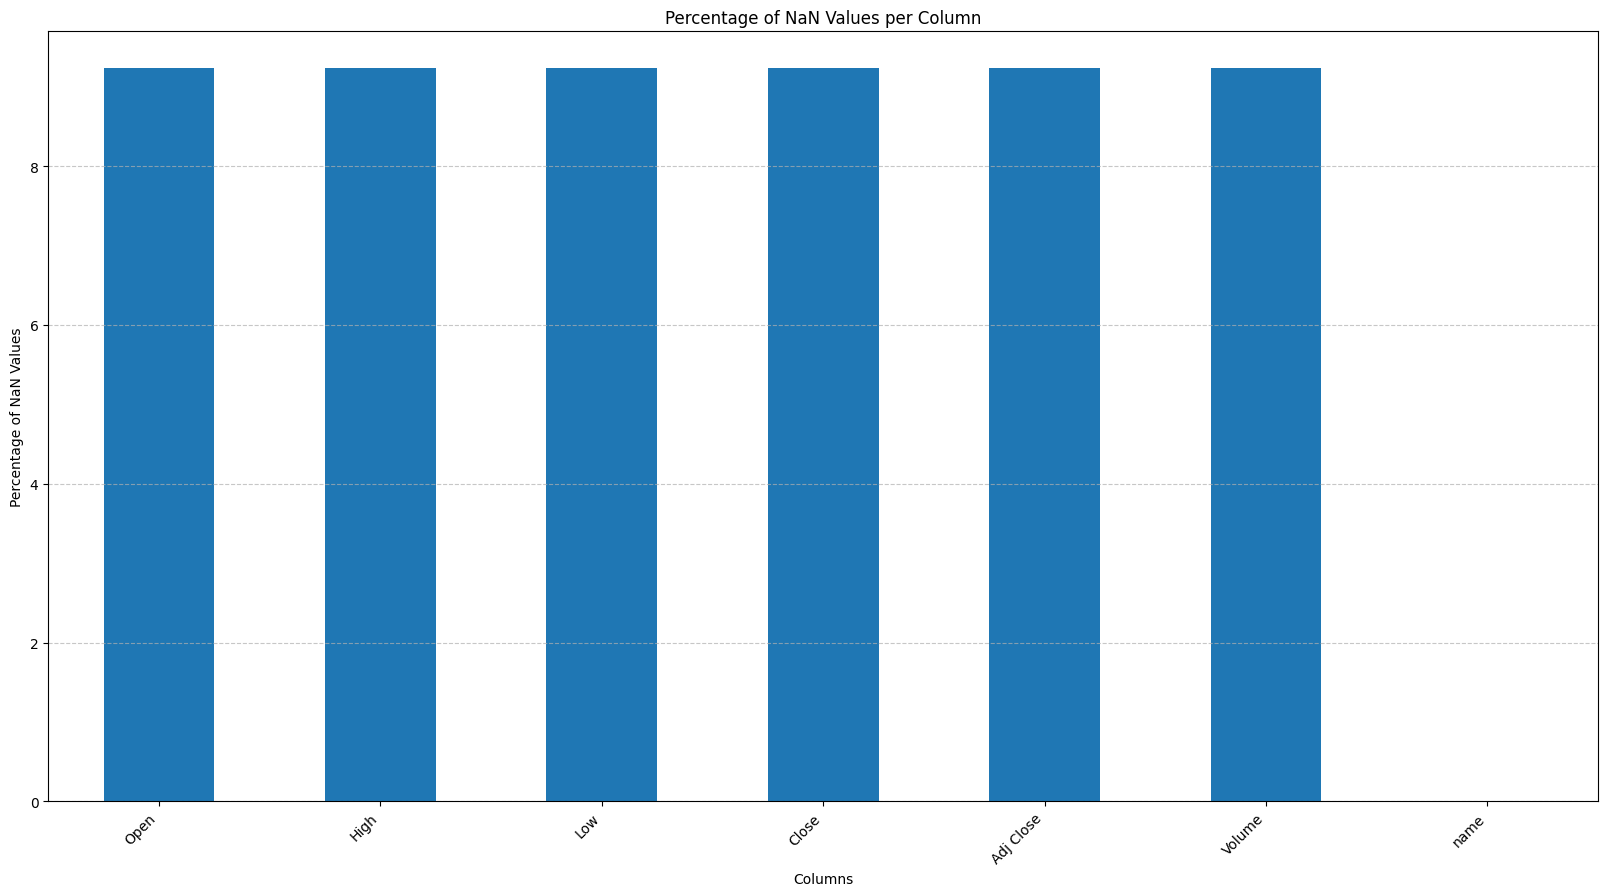

In [35]:
# calculate the percentage of NaN values for each column
nan_percentage = df.isnull().mean() * 100

# plotting
plt.figure(figsize=(20, 10))
nan_percentage.plot(kind='bar')
plt.title('Percentage of NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of NaN Values')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Given that the percentage of missing values is less than 2%, and considering insights from the gaps between missing values analyzed in the previous notebook, interpolation emerges as a suitable method for handling missing data in our current context.

**Future Work:** While interpolation serves as an effective immediate solution, exploring alternative methods for managing missing values could further enhance our model's performance and reliability.


In [36]:
df = df.interpolate()

## Downsampling for Weekly Analysis

Due to the project constraint requiring trades to be held on a weekly basis, it is necessary to resample our dataset to focus solely on weekly periods.

In [37]:
# resample to weekly data
weekly_df = df.resample('W-FRI').agg({
    'Open': ['first','mean','var'],
    'High': ['max','mean','var'],
    'Low': ['min','mean','var'],
    'Adj Close': ['last','mean','var'],
#     'Volume':['sum','mean','var'] #as volume is 0 we removed it 
})
weekly_df.columns = ['_'.join(col).rstrip('_') for col in weekly_df.columns.values]
weekly_df

,Open_first,Open_mean,Open_var,High_max,High_mean,High_var,Low_min,Low_mean,Low_var,Adj Close_last,Adj Close_mean,Adj Close_var
Date,,,,,,,,,,,,
2015-01-02,1.558094,1.558058,2.664500e-09,1.558458,1.558276,6.624800e-08,1.538746,1.548420,0.000187,1.557972,1.558033,7.442000e-09
2015-01-09,1.528608,1.517499,8.279187e-05,1.532004,1.520775,7.234024e-05,1.503624,1.511065,0.000048,1.508796,1.517535,8.128768e-05
2015-01-16,1.519203,1.519054,6.608654e-06,1.526601,1.523005,1.373523e-05,1.508000,1.511888,0.000015,1.518119,1.518916,7.038395e-06
2015-01-23,1.513800,1.510580,3.623628e-05,1.521667,1.516709,6.432362e-05,1.495461,1.504991,0.000029,1.501321,1.510621,3.241001e-05
2015-01-30,1.500195,1.509939,4.900221e-05,1.522209,1.515374,4.834629e-05,1.499340,1.505877,0.000046,1.507909,1.509817,5.256807e-05
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-05,1.273000,1.270355,6.458449e-06,1.277009,1.274726,3.192453e-06,1.261241,1.264239,0.000012,1.268408,1.270374,6.443624e-06
2024-01-12,1.271698,1.274544,4.973229e-06,1.278462,1.277183,6.699413e-07,1.267507,1.269408,0.000003,1.277776,1.274622,4.515548e-06
2024-01-19,1.273642,1.269648,1.474490e-05,1.274015,1.271477,2.801816e-06,1.259747,1.264929,0.000020,1.270987,1.269560,1.478190e-05


## Data Visualization

### Line Plot of Closing Prices

- **Line Plot Analysis**: The line plot of the adjusted closing prices reveals non-stationary behavior, indicating the presence of trends over time. To optimize the performance of our machine learning algorithms, it's essential to detrend this data and achieve stationarity.


In [38]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = weekly_df.index, y = weekly_df['Adj Close_last'].values,mode='lines',name = 'Adj Close'))

fig.show()

### Histogram Analysis

- **Comparative Histograms**: We have plotted histograms of closing prices for two distinct periods: before and after 2020. 

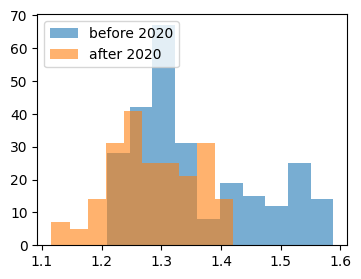

In [39]:
plt.figure(figsize=(4, 3))

close_first_half = weekly_df[weekly_df.index < '2020-01-01']['Adj Close_last']
close_second_half = weekly_df[weekly_df.index >= '2020-01-01']['Adj Close_last']

pyplot.hist(close_first_half,  alpha=0.6, label='before 2020')
pyplot.hist(close_second_half, alpha=0.6, label='after 2020')

pyplot.legend(loc='upper left')
pyplot.show()

To address the non-stationarity observed in the closing prices, we will shift our focus from the raw close prices to the weekly return rates. We'll define two types of returns:

- **Future Weekly Return**: The difference between the current week's closing price and the next week's closing price. This metric is what we aim to predict, focusing on its sign (upward or downward trend).

- **Past Weekly Return**: The difference between the current week's closing price and the previous week's closing price. This measure will serve as a feature in our predictive model, providing insight into past performance to aid in forecasting future trends.


In [40]:
weekly_df['return_close_feature'] = weekly_df['Adj Close_last'] - weekly_df['Adj Close_last'].shift(1)
weekly_df['return_close_target'] = weekly_df['Adj Close_last'] - weekly_df['Adj Close_last'].shift(-1)

***Stationarity Test with ADFuller***

To verify the effectiveness of this transformation, we will apply the Augmented Dickey-Fuller (ADF) test to the new feature, ensuring it exhibits stationarity. The test shows this 

In [41]:
column = 'return_close_feature'
print(f"Testing stationarity for column: {column}")
result = adfuller(weekly_df.dropna()[column])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# alpha = 0.05
if result[1] < 0.05:
    print(f"The data in '{column}' is likely stationary.\n")
else:
    print(f"The data in '{column}' is likely not stationary.\n")


Testing stationarity for column: return_close_feature
ADF Statistic: -17.004201
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
The data in 'return_close_feature' is likely stationary.



### Box Plot Analysis

The box plot reveals a significant increase in the number of local outliers during 2020, likely attributable to the market volatility induced by the COVID-19 pandemic. It shows we need to remove outliers before training our model.


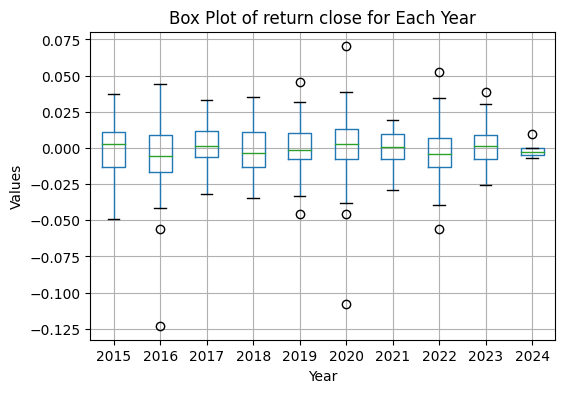

In [42]:
# Extracting year from the index and creating a 'Year' column
weekly_df['Year'] = weekly_df.index.year

# Using pandas pivot_table to rearrange the data, each year becomes a column
# This step is not strictly necessary but can make handling larger datasets more efficient
pivot_df = weekly_df.pivot_table(values='return_close_feature', index=weekly_df.index, columns='Year', aggfunc='first')

# Plotting
plt.figure(figsize=(6, 4))
pivot_df.boxplot()
plt.title('Box Plot of return close for Each Year')
plt.xlabel('Year')
plt.ylabel('Values')
plt.show()

### Lag Plot Analysis

To explore the relationship between the closing prices (and the returns of these closing prices) and their respective lags, we have utilized lag plots. 

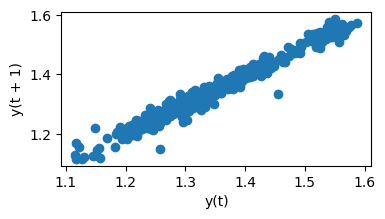

In [43]:
series = weekly_df['Adj Close_last']
plt.figure(figsize=(4, 2))
lag_plot(series,lag=1)
pyplot.show()

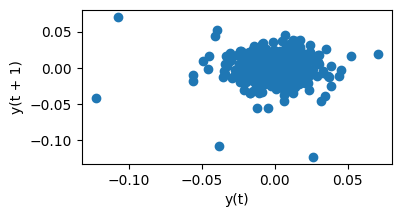

In [44]:
series = weekly_df['return_close_feature']
plt.figure(figsize=(4, 2))
lag_plot(series,lag=1)
pyplot.show()

As anticipated, the lag plot for the closing prices themselves displays a strong linear correlation, indicating a persistence or trend in stock prices over consecutive periods. However, this pattern does not hold for the return values. The return values exhibit much weaker correlations in their lag plots because returns tend to fluctuate more unpredictably from one period to the next. So we expect to have Autocorrelation of return should be const(=0) and damping autocorrelation for close itself, which is the case:
### Autocorrelation plot

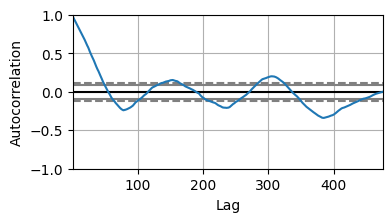

In [45]:
series = weekly_df['Adj Close_last']
plt.figure(figsize=(4, 2))
autocorrelation_plot(series)
pyplot.show()

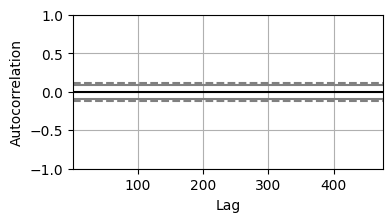

In [46]:
series = weekly_df['return_close_feature']
plt.figure(figsize=(4, 2))
autocorrelation_plot(series)
pyplot.show()

## Feature Augmentation

To improve the predictive capability of our machine learning model, we're introducing several new features:

1. **Lags of Daily Return**: Incorporating previous days' returns as features to capture temporal patterns in stock movements.
2. **Phase Space Features**: Adding features related to the phase space using Taken's embedding technique.
3. **Simple Moving Average (SMA)**: Including the SMA as a feature to provide insights into the overall trend direction over a specified period.
4. **Relative Strength Index (RSI)**: An technichal indicator (to be honest I don't why it's important but I've seen it everywhere so I will add it =)) ) 


In [47]:
#adding lag values
weekly_df['shift1'] = weekly_df['return_close_feature'].shift(1)
weekly_df['shift2'] = weekly_df['return_close_feature'].shift(2)
weekly_df['shift3'] = weekly_df['return_close_feature'].shift(3)
weekly_df['shift4'] = weekly_df['return_close_feature'].shift(4)

In [48]:
#simple moving average and making it non-stationary
weekly_df['sma2'] = ta.trend.sma_indicator(weekly_df['Adj Close_last'],window = 10)
weekly_df['sma3'] = ta.trend.sma_indicator(weekly_df['Adj Close_last'],window = 20)
weekly_df['sma4'] = ta.trend.sma_indicator(weekly_df['Adj Close_last'],window = 30)

weekly_df['sma2'] = weekly_df['sma2'] - weekly_df['sma2'].shift(1)
weekly_df['sma3'] = weekly_df['sma3'] - weekly_df['sma3'].shift(1)
weekly_df['sma4'] = weekly_df['sma4'] - weekly_df['sma4'].shift(1)

In [49]:
#indicator RSI 
weekly_df['RSI'] = RSI(weekly_df['Adj Close_last'], timeperiod=5)

### Phase Space Reconstruction

In this advanced feature engineering step, we delve into the daily activities within each week by leveraging Taken's Embedding Theorem for constructing a phase space from the daily time series data (`df`). This method allows us to capture the dynamics of daily fluctuations within the weekly trading period (and a short history of it), enriching our model with nuanced insights into stock behavior.

The reconstruction of phase space, followed by the application of Persistent Homology, enables us to quantify the entropy of loops—a measure directly related to the periodic behavior observed in the time series data. These entropy values serve as innovative features, enhancing our model in two critical ways:

1. **Intra-Week Dynamics**: By analyzing daily data within each week, we gain insights into the variability and patterns that occur at a finer temporal resolution.
2. **Trend Dynamics**: Understanding how upward and downward trends interplay and contribute to the overall data structure helps in capturing the essence of market movements.

Given the complexity of this approach, a comprehensive explanation is available in an article that details how topological data analysis can be applied to detect stock market crashes: [Detecting Stock Market Crashes with Topological Data Analysis](https://towardsdatascience.com/detecting-stock-market-crashes-with-topological-data-analysis-7d5dd98abe42). This resource further elaborates on the methodology and its relevance to our analysis.


In [50]:
#defining taken's embedding
embedding_dimension = 4
embedding_time_delay = 10
embedder = ts.SingleTakensEmbedding(
    parameters_type="fixed",
    dimension=embedding_dimension,
    time_delay=embedding_time_delay,
    n_jobs=-1,
)

In [51]:
#considering daily return 
df['return_close_feature'] = df['Adj Close'] - df['Adj Close'].shift(1)

In [52]:
# Initialize lists to store entropy values for dimensions 0 and 1, and persistence homology (PH) lists
entropy_list_dim1 = [] 
entropy_list_dim0 = [] 
ph_list = [] 

# Retrieve weekly data index for iteration
week_index = weekly_df.index

# Loop through each week in the index
for i in range(len(week_index)):
    # Ensure there are at least 10 previous weeks to form a meaningful time series
    if i - 10 >= 0:
        # Select the return close feature for the 10 weeks leading up to the current week, normalize it
        series = df[(week_index[i-10] < df.index) & (df.index < week_index[i])]['return_close_feature']
        series = series.dropna()  # Remove any missing values
        series = (series - np.min(series)) / (np.max(series) - np.min(series))  # Normalize the series
        
        # Use Takens' Embedding Theorem to reconstruct phase space from the normalized time series
        space = embedder.fit_transform(series)
        
        # Calculate Persistent Homology with homology dimensions 0 and 1
        PH1 = EuclideanCechPersistence(homology_dimensions=[0,1])
        ph = PH1.fit_transform([space])
        ph_list.append(ph[0])  # Append the persistence diagram to the list
        
        # Compute Persistence Entropy for each dimension, normalizing the result
        PE = PersistenceEntropy(normalize=True)
        ent = PE.fit_transform(ph)
        entropy_list_dim0.append(ent[0][0])  # Append dimension 0 entropy to its list
        entropy_list_dim1.append(ent[0][1])  # Append dimension 1 entropy to its list

    else:
        # For weeks where there aren't enough previous weeks, append default values
        ph_list.append(np.array([[0,0,1]]))
        entropy_list_dim0.append(0)
        entropy_list_dim1.append(0)

# This process captures the dynamic, periodic behavior within each week, using topological features.


In [53]:
#adding feature and its lags to the data
weekly_df['tda'] = entropy_list_dim0
weekly_df['tda_sh1'] = weekly_df['tda'].shift(1)
weekly_df['tda_sh2'] = weekly_df['tda'].shift(2)
weekly_df['tda_sh3'] = weekly_df['tda'].shift(3)

weekly_df['tda1'] = entropy_list_dim1
weekly_df['tda1_sh1'] = weekly_df['tda1'].shift(1)
weekly_df['tda1_sh2'] = weekly_df['tda1'].shift(2)
weekly_df['tda1_sh3'] = weekly_df['tda1'].shift(3)

In [54]:
weekly_df['return_open_feature'] = weekly_df['Open_first'] - weekly_df['Open_first'].shift(1) 
weekly_df['return_low_feature'] = weekly_df['Low_min'] - weekly_df['Low_min'].shift(1) 
weekly_df['return_high_feature'] = weekly_df['High_max'] - weekly_df['High_max'].shift(1) 

### Stationarity Test for Features

In this section, we conduct stationarity tests on all features intended for our classifier. Ensuring that our features are stationary is crucial, as non-stationary features can adversely affect model performance by introducing time-dependent errors. 

In [55]:
def test_stationarity(df, column_set):
    non_stat_list = []
    stat_list = [] 
    for column in column_set:
        print(f"Testing stationarity for column: {column}")
        result = adfuller(df.dropna()[column])
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        
        # Using a common significance level of 0.05 for stationarity
        if result[1] < 0.05:
            print(f"The data in '{column}' is likely stationary.\n")
            stat_list.append(column)
        else:
            print(f"The data in '{column}' is likely not stationary.\n")
            non_stat_list.append(column)
        
    return stat_list, non_stat_list


In [56]:
stat_list, non_stat_list = test_stationarity(weekly_df,column_set=weekly_df.columns)

Testing stationarity for column: Open_first
ADF Statistic: -3.112563
p-value: 0.025637
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
The data in 'Open_first' is likely stationary.

Testing stationarity for column: Open_mean
ADF Statistic: -3.064416
p-value: 0.029301
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
The data in 'Open_mean' is likely stationary.

Testing stationarity for column: Open_var
ADF Statistic: -12.750296
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
The data in 'Open_var' is likely stationary.

Testing stationarity for column: High_max
ADF Statistic: -3.014715
p-value: 0.033543
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
The data in 'High_max' is likely stationary.

Testing stationarity for column: High_mean
ADF Statistic: -3.103101
p-value: 0.026325
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
The data in 'High_mean' is likely stationary.

Testing stationarity for column: High_var
ADF Statistic: -10.24166

In [57]:
stat_list

['Open_first',
 'Open_mean',
 'Open_var',
 'High_max',
 'High_mean',
 'High_var',
 'Low_min',
 'Low_mean',
 'Low_var',
 'Adj Close_last',
 'Adj Close_mean',
 'Adj Close_var',
 'return_close_feature',
 'return_close_target',
 'shift1',
 'shift2',
 'shift3',
 'shift4',
 'sma2',
 'sma3',
 'sma4',
 'RSI',
 'tda',
 'tda_sh1',
 'tda_sh2',
 'tda_sh3',
 'tda1',
 'tda1_sh1',
 'tda1_sh2',
 'tda1_sh3',
 'return_open_feature',
 'return_low_feature',
 'return_high_feature']

In [58]:
non_stat_list

['Year']

## Correlation Analysis
The correlation analysis, visualized through the provided plot, indicates a high degree of correlation between the Open, High, and Low features with the Close feature, suggesting redundancy in information captured. Additionally, we plan to eliminate one feature from each pair exhibiting a correlation greater than 0.8, further reducing potential high variance in our model.

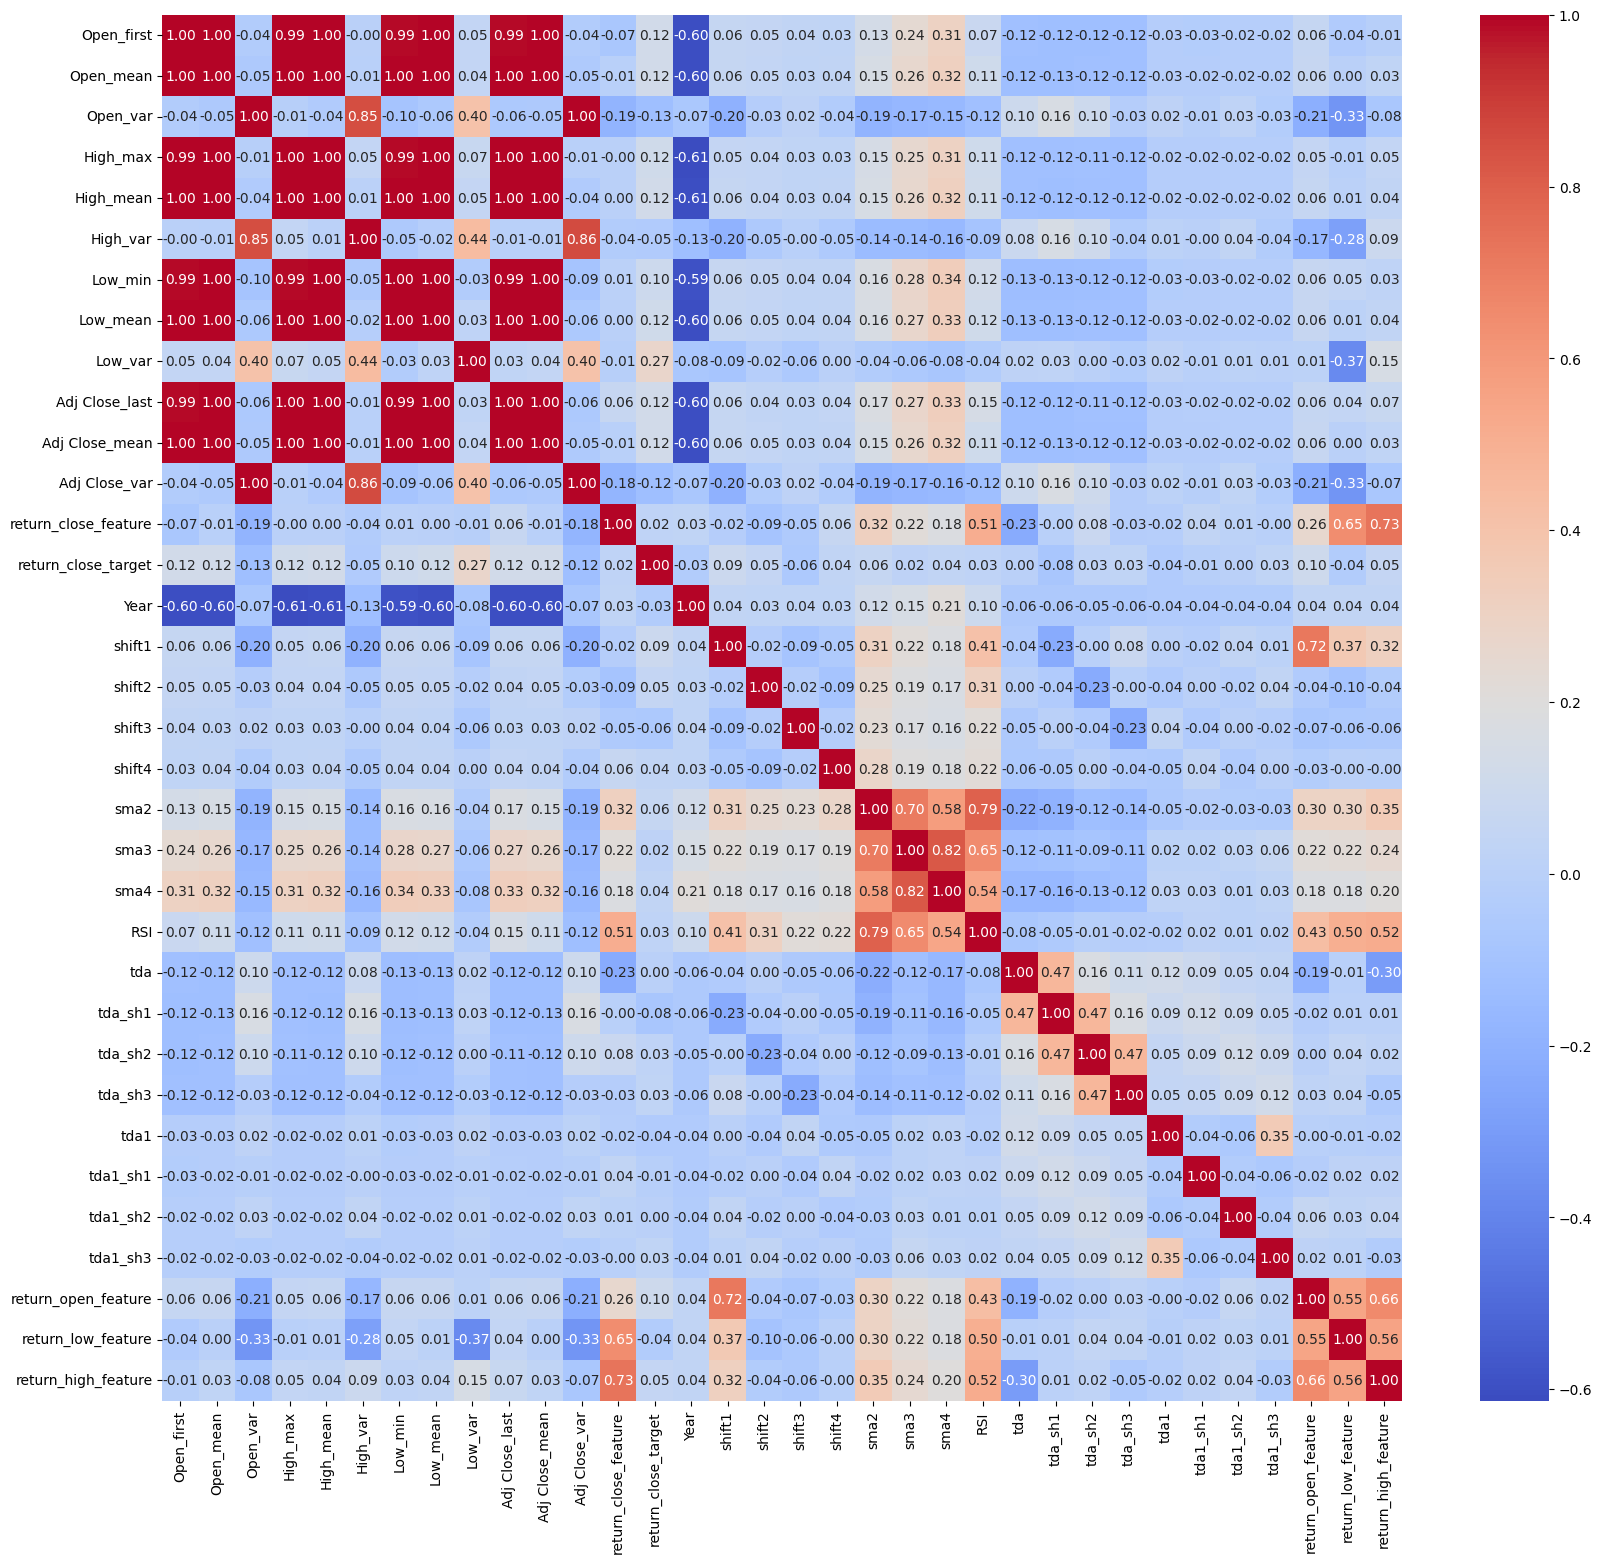

In [59]:
# calculate the correlation matrix
corr = weekly_df.corr()

# plotting
plt.figure(figsize=(20, 18))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', 
            xticklabels=corr.columns, yticklabels=corr.columns)

# show the plot
plt.show()

## ML Model Preparation and Evaluation

In this phase, we define our feature matrix `X` and target variable `Y`, followed by the segmentation of these datasets into training and testing subsets. A key part of our model evaluation strategy involves cross-validation, with a particular focus on the precision of class 1 (representing an upward trend) as our performance metric. **This metric choice aligns with the project's constraint**, which involves buying stocks, holding them for a week, and selling them the following week. A high precision for class 1 ensures confidence in our model's predictions, significantly reducing the risk associated with our trading strategy.

- **Future work:** We need more robust feature selection that can be considered as future work

In [70]:
X = weekly_df.dropna()[[
 'return_close_feature',
 'shift1',
 'shift2',
 'shift3',
 'shift4',
 'sma2',
 'sma3',
 'sma4',
 'RSI',
 'tda',
 'tda_sh1',
 'tda_sh2',
 'tda_sh3',
 'tda1',
 'tda1_sh1',
 'tda1_sh2',
 'tda1_sh3',
 'return_open_feature',
 'return_low_feature',
 'return_high_feature']]

Y = (1+np.sign(weekly_df.dropna()['return_close_target']))/2
Y_index_tmp = Y.index
Y = np.array([int(class_) for class_ in Y])

In [71]:
# train test split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, shuffle=False)


#### Imbalance checking:
here we check to see if we need to handle imbalance data or not- it is not necessary 

In [72]:
np.mean(Y_train)

0.5211267605633803

#### Metric function:
here we defined our metric as precision of class 1

In [73]:
#custom scorer for cv 
precision_scorer = make_scorer(precision_score, pos_label=1)

#### CV:
Here we perform cv for two different model AdaBoostClassifier and RandomForestClassifier and save them once we trained.

In [74]:
#model
model = AdaBoostClassifier()

# parameters
param_grid = {
    'n_estimators': [100, 150],  
    'learning_rate': [0.1,0.01],  
    'base_estimator': [DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2)],
}

# grid search init
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=precision_scorer, verbose=0)


grid_search.fit(X_train, Y_train)


best_model = grid_search.best_estimator_

/Users/shamsvahid2/opt/miniconda3/envs/bazar/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/Users/shamsvahid2/opt/miniconda3/envs/bazar/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/Users/shamsvahid2/opt/miniconda3/envs/bazar/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/Users/shamsvahid2/opt/miniconda3/envs/bazar/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/Users/shamsvahid2/opt/miniconda3/envs/bazar/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in v

/Users/shamsvahid2/opt/miniconda3/envs/bazar/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



In [75]:
print(grid_search.best_score_)

0.5201157804459691


In [76]:
# save the model 
filename = 'best_adaboost_model_GBPUSD=X.sav'
joblib.dump(best_model, filename)

['best_adaboost_model_GBPUSD=X.sav']

In [77]:
# parameters
param_grid = {
    'n_estimators': [150,100,200],  # Number of trees in the forest
    'max_depth': [ 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'bootstrap':[False,True]
}

#model
rf_model = RandomForestClassifier()

# grid search init
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring=precision_scorer,
                            n_jobs=-1, verbose=2)

grid_search.fit(X_train, Y_train)

best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [78]:
#save model 
filename = 'best_rf_model_GBPUSD=X.sav'
joblib.dump(best_model, filename)

['best_rf_model_GBPUSD=X.sav']

#### saving test data:
here we stored test data for testing model in live_tradin notebook (we add Adj close to it so we can have price during testing for evaluation)

In [79]:
X_test_to_live_trade = X_test.copy(deep=True)
X_test_to_live_trade['real_close'] = weekly_df.loc[X_test.index.values]['Adj Close_last']
X_test_to_live_trade.to_csv('X_test.csv')

[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=150; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_split=10, n_estimators=150; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_split=10, n_estimators=150; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, min_samples_split=5, n_estimators=150; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstr

[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=150; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_split=2, n_estimators=150; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_split=5, n_estimators=150; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=

[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_split=5, n_estimators=150; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_split=10, n_estimators=150; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap

[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_split=5, n_estimators=150; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_split=2, n_estimators=150; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_split=10, n_estimators=150; total time=   0.5s
[CV] END bootstrap